### Part 0. 安裝套件
[LINK](#p0)

### Part 1. 簡易操作中文BERT
[LINK](#p1)

### Part 2. 如何將模型應用於下游任務: NER命名實體標示
[LINK](#p2)

#### 步驟：
* 準備原始文本數據: 資料讀取與觀察
* 資料前處理(簡體轉繁體、句子段落切分)
* 將原始文本轉換成 BERT(RoBERTa) 相容的輸入格式、訓練模型、對新樣本做推論
    * 實作 Dataset
    * 實作 DataLoader
    * Fine-tune Model
    * 對新樣本做推論

#### 描述：

此程式將使用預先調整好的模型

對中文的醫療語料庫進行命名實體識別(NER, Name Entity Recognition)

模型是基於BERT模型，由於我們希望將模型遷移至**醫療病歷資料**使用，因此進行fine-tune訓練，使得模型能夠辨識醫療專有名詞

資料集是由醫渡雲（北京）技術有限公司編寫，並由醫渡雲公司組織專業的醫學團隊進行人工標註，文字內容以癌症醫療影像檢查與結論為主

整理後，訓練資料集包含800筆文字描述，並標記出文本中實體的起始位置與類型

實體的類別包含:

    1) 疾病和診斷：醫學上定義的疾病和醫生在臨床工作中對病因、病生理、分型分期等所作的判斷。

    2) 影像檢查： 影像檢查（X線、CT、MR、PETCT等）+造影+超聲+心電圖，未避免檢查操作與手術操作過多衝突，不包含此外其它的診斷性操作，如胃鏡、腸鏡等。

    3) 實驗室檢驗： 在實驗室進行的物理或化學檢查，本期特指臨床工作中檢驗科進行的化驗，不含免疫組化等廣義實驗室檢查

    4) 手術： 醫生在患者身體局部進行的切除、縫合等治療，是外科的主要治療方法。

    5) 藥物： 用於疾病治療的具體化學物質。

    6) 解剖部位： 指疾病、症狀和體徵發生的人體解剖學部位。
 

---

## Part 0. 安裝套件<a id='p0'></a>

首先，我們先安裝必要的套件，包含 huggingface 的 transformers 以及 pytorch。

huggingface transformers: https://github.com/huggingface/transformers

In [1]:
# !pip install transformers==4.6.1
# !pip install OpenCC

mac 執行這行:

In [2]:
# !pip3 install torch torchvision torchaudio
# !pip install pytorch-crf

windows 執行這行:

In [3]:
# !pip3 install torch==1.8.1+cpu torchvision==0.9.1+cpu torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install pytorch-crf

---

## Part 1. 簡易操作中文BERT<a id='p1'></a>

調用模型的方式可以直接引用套件後，指定模型名稱，下載官網的模型，
使用哈工大訊飛聯合實驗室所預訓練的 bert-wwm 模型。

HFL bert-wwm: https://github.com/ymcui/Chinese-BERT-wwm

In [4]:
import torch
import transformers
from transformers import AutoModelForPreTraining, AutoModelForSequenceClassification, AutoTokenizer

bert_tokenizer = AutoTokenizer.from_pretrained('hfl/chinese-bert-wwm')
bert_model = AutoModelForPreTraining.from_pretrained(pretrained_model_name_or_path = "hfl/chinese-bert-wwm") 
bert_model.eval()

Some weights of BertForPreTraining were not initialized from the model checkpoint at hfl/chinese-bert-wwm and are newly initialized: ['cls.predictions.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForPreTraining(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

我們將 input sentence 利用 tokenizer 變成 token，再把 token 轉成 index。這裡的 input sentence 可以換成任何你想要的句子。繁體或簡體都可以，因為預訓練時並沒有特別分繁簡體的資料集。

關於更多的 tokenizer 使用方法可以參考官方文檔：https://huggingface.co/transformers/main_classes/tokenizer.html#pretrainedtokeni

In [5]:
input_sentence = "坐在原地等待機遇，無異於盼天上掉餡餅。毫不猶豫儘快拿出行動，為夢想的實現創造條件，才是夢想成真的必經之路。"
tokenized = bert_tokenizer.tokenize(input_sentence)
ids = bert_tokenizer.convert_tokens_to_ids(tokenized)
print(tokenized)
print(ids)

['坐', '在', '原', '地', '等', '待', '機', '遇', '，', '無', '異', '於', '盼', '天', '上', '掉', '餡', '餅', '。', '毫', '不', '猶', '豫', '儘', '快', '拿', '出', '行', '動', '，', '為', '夢', '想', '的', '實', '現', '創', '造', '條', '件', '，', '才', '是', '夢', '想', '成', '真', '的', '必', '經', '之', '路', '。']
[1777, 1762, 1333, 1765, 5023, 2521, 3582, 6878, 8024, 4192, 4530, 3176, 4687, 1921, 677, 2957, 7630, 7619, 511, 3690, 679, 4348, 6499, 1029, 2571, 2897, 1139, 6121, 1240, 8024, 4158, 1918, 2682, 4638, 2179, 4412, 1201, 6863, 3454, 816, 8024, 2798, 3221, 1918, 2682, 2768, 4696, 4638, 2553, 5195, 722, 6662, 511]


接著我們把頭尾加上 special tokens

([CLS]= 101, [SEP] = 102, [MASK] = 103)

In [6]:
ids.insert(0, 101)
ids.append(102)
print(ids)
print(bert_tokenizer.convert_ids_to_tokens(ids))

[101, 1777, 1762, 1333, 1765, 5023, 2521, 3582, 6878, 8024, 4192, 4530, 3176, 4687, 1921, 677, 2957, 7630, 7619, 511, 3690, 679, 4348, 6499, 1029, 2571, 2897, 1139, 6121, 1240, 8024, 4158, 1918, 2682, 4638, 2179, 4412, 1201, 6863, 3454, 816, 8024, 2798, 3221, 1918, 2682, 2768, 4696, 4638, 2553, 5195, 722, 6662, 511, 102]
['[CLS]', '坐', '在', '原', '地', '等', '待', '機', '遇', '，', '無', '異', '於', '盼', '天', '上', '掉', '餡', '餅', '。', '毫', '不', '猶', '豫', '儘', '快', '拿', '出', '行', '動', '，', '為', '夢', '想', '的', '實', '現', '創', '造', '條', '件', '，', '才', '是', '夢', '想', '成', '真', '的', '必', '經', '之', '路', '。', '[SEP]']


#### 接著我們定義一個方便我們做 masking 的函數

In [7]:
def mask(masked, start, end):
    """
    Inputs
        masked: input sentence to be masked, should be a list of intergers
        start: the starting position of mask
        end: the ending position of mask
    """
    if start < end:
        for i in range(start,end + 1):
            masked[i] = 103
    else:
        for i in range(end, start + 1):
            masked[i] = 103  

產生 mask 的句子。mask 函數的最後兩個 arguement 可以改成自己要的 start position 跟 end position。

In [8]:
masked = ids.copy()
mask(masked, 17, 18)
tokens = bert_tokenizer.convert_ids_to_tokens(masked)[1:-1]
print(tokens)

['坐', '在', '原', '地', '等', '待', '機', '遇', '，', '無', '異', '於', '盼', '天', '上', '掉', '[MASK]', '[MASK]', '。', '毫', '不', '猶', '豫', '儘', '快', '拿', '出', '行', '動', '，', '為', '夢', '想', '的', '實', '現', '創', '造', '條', '件', '，', '才', '是', '夢', '想', '成', '真', '的', '必', '經', '之', '路', '。']


最後把被 mask 過的 sequence 丟進 model 裡面，看看會預測出什麼東西。

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)
x = torch.tensor([masked]).to(device)

pred = bert_model(x)[0]
pred = pred.argmax(-1).squeeze().cpu().numpy()
pred_tokens = bert_tokenizer.convert_ids_to_tokens(pred)[1:-1]
print(pred_tokens)

['坐', '在', '原', '地', '等', '待', '機', '遇', '，', '無', '異', '於', '盼', '天', '上', '掉', '下', '石', '。', '毫', '不', '猶', '豫', '儘', '快', '拿', '出', '行', '動', '，', '為', '夢', '想', '的', '實', '現', '創', '造', '條', '件', '，', '才', '是', '夢', '想', '成', '真', '的', '必', '經', '之', '路', '。']


可以把 input sentence 換成其他句子，把 [MASK] 放在其他地方，熟悉一下 BERT 的操作方式，並且觀察看看會發生什麼事。

---

## Part 2. 如何將模型應用於下游任務: NER命名實體標示<a id=p2></a>
在這個部分我們利用 chinese-roberta-wwm-ext作為基礎架構，進行中文電子病歷資料執行NER命名實體標示。

調整過的模型已存放在資料夾 `./experiments/pretrain/`中，

以下程式將著重在了解模型訓練需要的流程，並且直接載入調整過的模型，簡化訓練過程，

### 直接使用模型進行標註可以直接跳至 [**對新樣本進行推論**](#INFERENCE)程式區塊

訓練與測試原始資料為在資料夾`data`中的`train.json`，`test.json`

In [1]:
import pandas as pd
import json
import numpy as np
import config  # 事先在config.py檔案中，定義操作和訓練模型時的各項參數位置

### 讀取原始資料

In [6]:
with open('./data/train.json',encoding='utf-8-sig') as read_file:
    data = []
    for line in read_file.readlines():
        dic = json.loads(line)
        data.append(dic)
        
print(f"""
[資料筆數] {len(data)}
印出第一筆資料: 

[原始文字]

{data[0]['originalText']}

[標籤]

{data[0]['entities']}""")


[資料筆數] 800
印出第一筆資料: 

[原始文字]

，患者3月前因“直肠癌”于在我院于全麻上行直肠癌根治术（DIXON术），手术过程顺利，术后给予抗感染及营养支持治疗，患者恢复好，切口愈合良好。，术后病理示：直肠腺癌（中低度分化），浸润溃疡型，面积3.5*2CM，侵达外膜。双端切线另送“近端”、“远端”及环周底部切除面未查见癌。肠壁一站（10个）、中间组（8个）淋巴结未查见癌。，免疫组化染色示：ERCC1弥漫（+）、TS少部分弱（+）、SYN（-）、CGA（-）。术后查无化疗禁忌后给予3周期化疗，，方案为：奥沙利铂150MG D1，亚叶酸钙0.3G+替加氟1.0G D2-D6，同时给与升白细胞、护肝、止吐、免疫增强治疗，患者副反应轻。院外期间患者一般情况好，无恶心，无腹痛腹胀胀不适，无现患者为行复查及化疗再次来院就诊，门诊以“直肠癌术后”收入院。   近期患者精神可，饮食可，大便正常，小便正常，近期体重无明显变化。

[標籤]

[{'label_type': '疾病和诊断', 'overlap': 0, 'start_pos': 8, 'end_pos': 11}, {'label_type': '手术', 'overlap': 0, 'start_pos': 21, 'end_pos': 35}, {'label_type': '疾病和诊断', 'overlap': 0, 'start_pos': 78, 'end_pos': 95}, {'label_type': '解剖部位', 'overlap': 0, 'start_pos': 139, 'end_pos': 159}, {'end_pos': 234, 'label_type': '药物', 'overlap': 0, 'start_pos': 230}, {'end_pos': 247, 'label_type': '药物', 'overlap': 0, 'start_pos': 243}, {'end_pos': 255, 'label_type': '药物', 'overlap': 0, 'start_pos': 252}, {'label_type': '解剖部位', 'overlap': 0, 'start_pos': 276, 'end_pos': 277}, {'label_ty

### 觀察資料

In [7]:
# 查看訓練資料各類別數量分布
label_dict = {}
for item in data:
    for entity in item['entities']:
        if entity['label_type'] not in label_dict:
            label_dict[entity['label_type']] = 1
        else:
            label_dict[entity['label_type']] += 1
label_dict

{'疾病和诊断': 3595,
 '手术': 813,
 '解剖部位': 7070,
 '药物': 1585,
 '影像检查': 865,
 '实验室检验': 1168}

#### 以圖表顯示

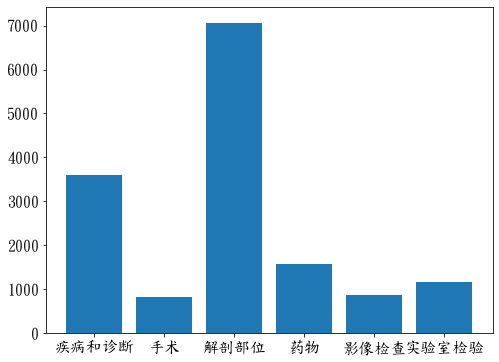

In [8]:
import matplotlib.pyplot as plt
import matplotlib
#中文顯示設定
# windows
plt.rcParams['font.family'] = 'DFKai-SB' # 可體換字體 : DFKai-SB Microsoft JhengHei
# Mac需改使用下面這行
# plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

plt.rcParams.update({'font.size': 16}) # 字體大小
plt.rcParams['axes.unicode_minus'] = False  # （解決座標軸負數的負號顯示問題）

keys = label_dict.keys()
values = label_dict.values()

plt.figure(figsize = (8,6))

plt.bar(keys, values)
plt.xticks(range(len(label_dict)), list(label_dict.keys()))
plt.show()

### 使用OpenCC對簡體中文資料集，轉換成繁體中文資料

In [9]:
from opencc import OpenCC

# 以一筆資料測試
cc = OpenCC('s2twp') # s2twp: 簡體中文 -> 繁體中文 (台灣, 包含慣用詞轉換)

sentence = '，患者3月前因“直肠癌”于在我院于全麻上行直肠癌根治术（DIXON术），手术过程顺利，术后给予抗感染及营养支持治疗，患者恢复好，切口愈合良好。，术后病理示：直肠腺癌（中低度分化），浸润溃疡型，面积3.5*2CM，侵达外膜。双端切线另送“近端”、“远端”及环周底部切除面未查见癌。肠壁一站（10个）、中间组（8个）淋巴结未查见癌。，免疫组化染色示：ERCC1弥漫（+）、TS少部分弱（+）、SYN（-）、CGA（-）。术后查无化疗禁忌后给予3周期化疗，，方案为：奥沙利铂150MG D1，亚叶酸钙0.3G+替加氟1.0G D2-D6，同时给与升白细胞、护肝、止吐、免疫增强治疗，患者副反应轻。院外期间患者一般情况好，无恶心，无腹痛腹胀胀不适，无现患者为行复查及化疗再次来院就诊，门诊以“直肠癌术后”收入院。 近期患者精神可，饮食可，大便正常，小便正常，近期体重无明显变化。'
sentence_new = cc.convert(sentence)

print(f"""
簡體轉繁體中文：
[轉換前]
{sentence}

[轉換後]
{sentence_new}
""")


簡體轉繁體中文：
[轉換前]
，患者3月前因“直肠癌”于在我院于全麻上行直肠癌根治术（DIXON术），手术过程顺利，术后给予抗感染及营养支持治疗，患者恢复好，切口愈合良好。，术后病理示：直肠腺癌（中低度分化），浸润溃疡型，面积3.5*2CM，侵达外膜。双端切线另送“近端”、“远端”及环周底部切除面未查见癌。肠壁一站（10个）、中间组（8个）淋巴结未查见癌。，免疫组化染色示：ERCC1弥漫（+）、TS少部分弱（+）、SYN（-）、CGA（-）。术后查无化疗禁忌后给予3周期化疗，，方案为：奥沙利铂150MG D1，亚叶酸钙0.3G+替加氟1.0G D2-D6，同时给与升白细胞、护肝、止吐、免疫增强治疗，患者副反应轻。院外期间患者一般情况好，无恶心，无腹痛腹胀胀不适，无现患者为行复查及化疗再次来院就诊，门诊以“直肠癌术后”收入院。 近期患者精神可，饮食可，大便正常，小便正常，近期体重无明显变化。

[轉換後]
，患者3月前因“直腸癌”於在我院於全麻上行直腸癌根治術（DIXON術），手術過程順利，術後給予抗感染及營養支援治療，患者恢復好，切口癒合良好。，術後病理示：直腸腺癌（中低度分化），浸潤潰瘍型，面積3.5*2CM，侵達外膜。雙端切線另送“近端”、“遠端”及環周底部切除面未查見癌。腸壁一站（10個）、中間組（8個）淋巴結未查見癌。，免疫組化染色示：ERCC1瀰漫（+）、TS少部分弱（+）、SYN（-）、CGA（-）。術後查無化療禁忌後給予3週期化療，，方案為：奧沙利鉑150MG D1，亞葉酸鈣0.3G+替加氟1.0G D2-D6，同時給與升白細胞、護肝、止吐、免疫增強治療，患者副反應輕。院外期間患者一般情況好，無噁心，無腹痛腹脹脹不適，無現患者為行復查及化療再次來院就診，門診以“直腸癌術後”收入院。 近期患者精神可，飲食可，大便正常，小便正常，近期體重無明顯變化。



### 對整體資料及進行操作

#### 先定義資料讀取路徑

In [10]:
input_path_train = './data/train.json'
output_path_train = './data/train_s2twp.json' # 轉成繁體後輸出的檔名

input_path_test = './data/test.json'
output_path_test = './data/test_s2twp.json' # 轉成繁體後輸出的檔名

In [11]:
# 定義簡體轉繁體轉換函式 opencc_s2tw
def opencc_s2tw(inputpath, outputpath):
    """
    對訓練資料與測試資料執行簡體繁體轉換，除病歷資料外，也對標籤進行轉換
    原始資料集中，
    以 originalText 代表原始文字，
    entities 表示標籤的名稱與對應原始文字的索引
    
    """
    # 讀資料
    with open(inputpath, encoding='utf-8-sig') as read_file:
        papers = []
        for line in read_file.readlines():
            dic = json.loads(line)
            dic['originalText'] = cc.convert(dic['originalText'])

            for entity in dic['entities']:
                entity['label_type'] = cc.convert(entity['label_type'])
            papers.append(dic)
            
    # 寫出資料到檔案 outputpath
    with open(outputpath, 'w', encoding='utf-8-sig') as fp:
        for line in papers:
            line = json.dump(line,fp, ensure_ascii=False)
            fp.write('\n')
            
    print('----------------轉換成功，輸出檔案{}-------------------'.format(outputpath))

In [12]:
# 呼叫函式opencc_s2tw
opencc_s2tw(input_path_train, output_path_train)
opencc_s2tw(input_path_test, output_path_test)

----------------轉換成功，輸出檔案./data/train_s2twp.json-------------------
----------------轉換成功，輸出檔案./data/test_s2twp.json-------------------


### 資料集處理
* 將資料處理成，NER任務需要的 BIO格式
    * B-實體類別 : 表示實體的起點字
    * I-實體類別 : 表示實體起點以外的字
    * O : 非實體的字

In [13]:
# 讀取剛才轉完成的繁體檔案，輸出BIO格式資料，以npz檔案存放

# 訓練集路徑
input_path_train = './data/train_s2twp.json'
output_path_train = './data/train_s2twp.npz'

# 測試集路徑
input_path_test = './data/test_s2twp.json'
output_path_test = './data/test_s2twp.npz'

#### 定義一個將文字檔案轉成，BIO格式的函式
以下程式會先將病歷文字，跟BIO格是label結合後，

將資料每30個字切分成一筆資料，目的是減少訓練時間，

並且捨棄掉切到標籤B、I中間位置的錯誤資料。

In [14]:
def BIOpreprocess(input_path, output_path):
    MAX_LENGTH = config.max_length
    word_list = []
    label_list = []
    with open(input_path, encoding='utf-8-sig') as f:
        # 先讀取資料到記憶體中，再逐行處理
        for line in f.readlines():
            # loads()：用來處理記憶體中的json物件，strip去除可能存在的空格
            json_line = json.loads(line.strip())
            # 讀取 key= 'originalText'的資料
            text = json_line['originalText']
            words = list(text)
            # 如果沒有label，則回傳none
            label_entities = json_line.get('entities', None)
            labels = ['O'] * len(words)

            if label_entities is not None:
                for i in label_entities:
                    labels[i['start_pos']]='B-'+i['label_type']
                    labels[i['start_pos']+1: i['end_pos']] = ['I-'+i['label_type']]*(i['end_pos']-i['start_pos']-1)

            # 把文字跟label每 MAX_LENGTH 個字左右分成一組，縮小資料長度
            sub_word = [words[i:i + MAX_LENGTH] for i in range(0, len(words), MAX_LENGTH)]
            sub_label = [labels[i:i + MAX_LENGTH] for i in range(0, len(labels), MAX_LENGTH)]

            # 刪除剛好切到label詞中間的資料
            for w in range(len(sub_word)):
                if sub_label[w][0] =='O' and sub_label[w][-1] =='O':
                    word_list.append(sub_word[w])
                    label_list.append(sub_label[w])
                    

        print("樣本數：", len(word_list))
        # 保存成二進位文件
        np.savez_compressed(output_path, words=word_list, labels=label_list, dtype='object')
        print("--------data process DONE! output_path: {}--------".format(output_path))

#### 呼叫函式

In [15]:
BIOpreprocess(input_path_train, output_path_train)
BIOpreprocess(input_path_test, output_path_test)

樣本數： 8078


C:\Users\AICenterM365Lic\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


--------data process DONE! output_path: ./data/train_s2twp.npz--------
樣本數： 1566
--------data process DONE! output_path: ./data/test_s2twp.npz--------


#### 由於示範僅能使用CPU運算
#### 先選擇 10%資料作為訓練資料

#### 資料切分，將訓練資料分離出 驗證集

In [16]:
from sklearn.model_selection import train_test_split

def dev_split(dataset_dir):
    """split dev set"""
    data = np.load(dataset_dir, allow_pickle=True)
    words = data["words"]
    labels = data["labels"]
    x_train, x_dev, y_train, y_dev = train_test_split(words, labels, test_size=0.1, random_state=0)
    return x_train, x_dev, y_train, y_dev

def cpu_dev_split(dataset_dir):
    """split dev set"""
    data = np.load(dataset_dir, allow_pickle=True)
    words = data["words"]
    labels = data["labels"]
    
    _, x_mini_train, _, y_mini_train = train_test_split(words, labels, test_size=0.1, random_state=0)
    x_train, x_dev, y_train, y_dev = train_test_split(x_mini_train, y_mini_train, test_size=0.1, random_state=0)
    return x_train, x_dev, y_train, y_dev

def load_dev(mode):
    if mode == 'train with GPU':
        word_train, word_dev, label_train, label_dev = dev_split(output_path_train)
    elif mode =='train with CPU':
        word_train, word_dev, label_train, label_dev = cpu_dev_split(output_path_train)
    else:
        word_train = None
        label_train = None
        word_dev = None
        label_dev = None
    print("--------data split DONE!--------")
    return word_train, word_dev, label_train, label_dev

if config.device == torch.device('cpu') :
    print('train with CPU')
    word_train, word_dev, label_train, label_dev = load_dev('train with CPU')
else:
    word_train, word_dev, label_train, label_dev = load_dev('train with GPU')
# 以參數 'train with CPU' 告訴函式選擇少量資料
print('訓練樣本數',len(word_train))

train with CPU
--------data split DONE!--------
訓練樣本數 727


### 將資料整理成 BERT模型能夠處理的形式
#### 實作一個 `Dataset` 並將原始文本轉換成 BERT 相容的格式

In [18]:
# 首先定義標籤對應的 id，以教學為目的先將標籤定義呈現在此，
# 使用自己的資料集的話，需要同時變更這裡和 config.py內容

label2id = {
    "O": 0,
    "B-疾病和診斷": 1,
    "B-影像檢查": 2,
    "B-實驗室檢驗": 3,
    'B-手術': 4,
    'B-藥物': 5,
    'B-解剖部位': 6,
    "I-疾病和診斷": 7,
    "I-影像檢查": 8,
    "I-實驗室檢驗": 9,
    'I-手術': 10,
    'I-藥物': 11,
    'I-解剖部位': 12
}

id2label = {_id: _label for _label, _id in list(label2id.items())}

#### 實做一個名為`NERDataset`的`Dataset` Class

In [19]:
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer

model_tokenizer = 'bert-base-chinese'

class NERDataset(Dataset):
    def __init__(self, words, labels, word_pad_idx=0, label_pad_idx=-1):
        self.tokenizer = BertTokenizer.from_pretrained( model_tokenizer, do_lower_case=True) # 斷詞使用的模型
        self.label2id = label2id
        self.id2label = {_id: _label for _label, _id in list(label2id.items())}
        self.dataset = self.preprocess(words, labels) # 呼叫 preprocess對原始資料進行轉換，得到可供模型訓練的格式
        self.word_pad_idx = word_pad_idx
        self.label_pad_idx = label_pad_idx
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def preprocess(self, origin_sentences, origin_labels):
        """
        word: 將原始文字切成token，加入給模型識別用的特殊符號[CLS]，
        sentence: 用tokenizer轉成文字編碼，並加入一個存放實際內文索引位置的array，讓模型知道需要處裡的文字位置
        label: 將原始標籤，以我們是先定義的id對照表，取得數字形式的標籤
        
        examples: 
            word:['[CLS]', '浙', '商', '银', '行', '企', '业', '信', '贷', '部']
            sentence:([101, 3851, 1555, 7213, 6121, 821, 689, 928, 6587, 6956],
                        array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))
            label:[3, 13, 13, 13, 0, 0, 0, 0, 0]
        """
        data = []
        sentences = []
        labels = []
        
        for line in origin_sentences:
            words = []
            word_lens = []
            
            # 對文字進行編碼
            for token in line:
                words.append(self.tokenizer.tokenize(token)) # 句子切分成單字
                word_lens.append(len(token))
                
            # 變成單字列表，開頭加上特殊符號 [CLS]
            words = ['[CLS]'] + [item for token in words for item in token]
            
            # 建立一個存放實際內文索引位置的array，讓模型識別需要處裡的文字位置
            token_start_idxs = 1 + np.cumsum([0] + word_lens[:-1])
            
            # 組合編碼後的句子，與際內文索引位置的array
            sentences.append((self.tokenizer.convert_tokens_to_ids(words), token_start_idxs))
        
        # 對文字標籤進行編碼
        for tag in origin_labels:
            label_id = [self.label2id.get(t) for t in tag]
            labels.append(label_id)
        
        # 所有資料轉成 tensor 資料型態，模型運算需要
        for sentence, label in zip(sentences, labels):
            tmp = []
            snt = []
            sentence_tensor1 = torch.tensor(sentence[0])
            sentence_tensor2 = torch.tensor(sentence[1])
            tmp.append(sentence_tensor1)
            tmp.append(sentence_tensor2)
            label = torch.tensor(label, dtype=torch.long)
            data.append((tmp, label))
            
        return data
    
    # 定義回傳一筆訓練 / 測試數據的函式
    def __getitem__(self, idx):
        """sample data to get batch"""
        words = self.dataset[idx][0]
        
        tokens_tensor = words[0]
        segments_tensor = words[1]
        label_tensor = self.dataset[idx][1]

        return [tokens_tensor, segments_tensor, label_tensor]

    def __len__(self):
        """get dataset size"""
        return len(self.dataset)

#### 將先前切分的訓練和驗證樣本，以`NERDataset`進行讀取和轉換

In [21]:
train_dataset = NERDataset(word_train, label_train)
dev_dataset = NERDataset(word_dev, label_dev)

#### 看看第一個訓練樣本轉換前後的格式差異：

In [22]:
# 選擇第一個樣本
sample_idx = 0
text = word_train[sample_idx] # 選擇第一筆尚未編碼的訓練資料

tokens_tensor, mask, label_tensor = train_dataset[sample_idx] # 取得以 NERDataset進行讀取和轉換的結果

# 使用 BertTokenizer 將 tokens_tensor 從編碼還原成文本
tokenizer = BertTokenizer.from_pretrained(model_tokenizer, do_lower_case=True)
tokens = tokenizer.convert_ids_to_tokens(tokens_tensor)

# 把單字組成句子
combined_text = "".join(tokens)

print(f"""[原始文本]
{text}
--------------------

[Dataset 回傳的 tensors]

tokens_tensor 
長度: {len(tokens_tensor)}:

{tokens_tensor}

label_tensor 
長度: {len(label_tensor)}:

{label_tensor}

--------------------

[還原 tokens_tensors]
{combined_text}
""")


[原始文本]
['1', '（', '+', '+', '+', '）', '，', 'D', 'E', 'S', 'M', 'I', 'N', '（', '-', '）', '，', 'H', '-', 'C', 'A', 'L', 'D', 'E', 'S', 'M', 'O', 'N', '（', '-']
--------------------

[Dataset 回傳的 tensors]

tokens_tensor 
長度: 31:

tensor([ 101,  122, 8020,  116,  116,  116, 8021, 8024,  146,  147,  161,  155,
         151,  156, 8020,  118, 8021, 8024,  150,  118,  145,  143,  154,  146,
         147,  161,  155,  157,  156, 8020,  118])

label_tensor 
長度: 30:

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])

--------------------

[還原 tokens_tensors]
[CLS]1（+++），desmin（-），h-caldesmon（-



#### 實作一個 `DataLoader` 

實作可以一次回傳一個 mini-batch 的`DataLoader`，

In [23]:
# build data_loader
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


# 這個函式的輸入 `batch` 是一個 list，裡頭的每個 element 都是
# 剛剛定義的 `NERDataset` 回傳的一個樣本，每個樣本都包含 3 tensors：
# - tokens_tensor : 將文本加上特殊符號後，編碼後的結果
# - segments_tensor : 原始文本在 tokens_tensor 中的索引
# - label_tensor : 表示每個詞所對應的 label id
def create_mini_batch(batch):
    """
    將每個batch資料補成相同長度
    """
    tokens_tensor = [x[0] for x in batch]
    segments_tensor = [x[1] for x in batch]
    label_tensor = [x[2] for x in batch]

    # padding and aligning
    # zero pad 到同一序列長度
    batch_data = pad_sequence(tokens_tensor, batch_first=True)
    
    # 轉換segments_tensor，全部轉成 1，再 zero pad 到同一序列長度
    # 表示有label位置=1，沒有的為 = 0
    for i in segments_tensor:
        i[i!=0] = 1 
    batch_label_starts = pad_sequence(segments_tensor, batch_first=True)
    
    # label_tensor，以 -1 補到相同長度
    batch_labels = pad_sequence(label_tensor, 
                                batch_first=True, padding_value=-1)

    return batch_data, batch_label_starts, batch_labels

In [25]:
# build data_loader
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, collate_fn=create_mini_batch)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=create_mini_batch)

print("--------Get Dataloader!--------")

--------Get Dataloader!--------


#### 拿出一個 batch 看看：

In [27]:
data = next(iter(train_loader))

tokens_tensors, segments_tensors, label_ids = data
# - tokens_tensor : 將文本加上特殊符號後，編碼後的結果，0代表空的區域
# - segments_tensor : 一個批次的資料經過長度補齊後，以1表示文本位置，0代表空的區域
# - label_tensor : 編碼後的標籤，-1代表空的區域

# tokens_tensors包含[CLS]特殊符號，所以長度多 1
print(f"""
[一個batch tensor尺寸]

tokens_tensors : {tokens_tensors.shape}
segments_tensors.shape : {segments_tensors.shape}
label_ids : {label_ids.shape}

------------------------------------------------
tokens_tensors: 

{tokens_tensors}
------------------------------------------------
segments_tensors:

{segments_tensors}
------------------------------------------------
label_ids:

{label_ids}
""")


[一個batch tensor尺寸]

tokens_tensors : torch.Size([16, 31])
segments_tensors.shape : torch.Size([16, 30])
label_ids : torch.Size([16, 30])

------------------------------------------------
tokens_tensors: 

tensor([[ 101, 8024, 2642, 5442,  123,  121,  122,  123, 2399,  126, 3299, 1139,
         4412, 1411, 1710, 1737, 7432, 8024,  845,  678, 5592, 6956,  679, 6900,
         8024, 4158, 7403, 4578, 8024, 4192, 3209],
        [ 101, 5440, 2719, 4158,  856, 1146, 1265, 7821, 4311, 5169, 5528, 4617,
          511, 5631, 2414, 5440, 2719, 2152, 7534, 4617,  151,  151,  143,  123,
         3309,  511,  123,  121,  122,  127,  118],
        [ 101, 8024, 2642, 5442,  123,  121,  122,  126,  118,  121,  130,  118,
          122,  126, 1728,  100, 5592, 4578,  845, 1920,  912, 2595, 4311, 5424,
         2715, 3121, 6365,  122, 3299,  100, 2218],
        [ 101,  510, 1164, 2228, 5023, 3780, 4615, 2527, 1962, 6752, 8024, 2456,
         6359, 2642, 5442, 6868,  671, 3635, 2130, 1587, 1094, 5548, 68

### 建立模型
在BERT模型架構下，加入分類器和CRF運算層，達成NER任務

CRF(Conditional Random Field) 條件隨機場是自然語言處理領域常用的算法之一，常用於句法分析、命名實體識別、詞性標註等。

[CRF原理補充](https://zhuanlan.zhihu.com/p/44042528)

In [28]:
# 定義模型架構

# from transformers.modeling_bert import *
from transformers.models.bert.modeling_bert import *  # 依套件版本不同，import方式可能為此行或前一行
from torch.nn.utils.rnn import pad_sequence
from torchcrf import CRF

class BertNER(BertPreTrainedModel):
    def __init__(self, config):
        super(BertNER, self).__init__(config)
        self.num_labels = config.num_labels
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.crf = CRF(config.num_labels, batch_first=True)

        self.init_weights()

    def forward(self, input_data, token_type_ids=None, attention_mask=None, labels=None,
                position_ids=None, inputs_embeds=None, head_mask=None):
        
        input_ids, input_token_starts = input_data

        outputs = self.bert(input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            position_ids=position_ids,
                            head_mask=head_mask,
                            inputs_embeds=inputs_embeds)
        sequence_output = outputs[0]

        # 去除[CLS]標籤等位置，獲得和label對齊的pre_label表示
        origin_sequence_output = [layer[starts.nonzero().squeeze(1)]
                                  for layer, starts in zip(sequence_output, input_token_starts)]
        # 將sequence_output的pred_label维度padding到最大長度
        padded_sequence_output = pad_sequence(origin_sequence_output, batch_first=True)
        # dropout pred_label的一部分feature
        padded_sequence_output = self.dropout(padded_sequence_output)
        # 得到判別值
        logits = self.classifier(padded_sequence_output)
        
        outputs = (logits,)
        if labels is not None:
            loss_mask = labels.gt(-1)
            loss = self.crf(logits, labels, loss_mask) * (-1)
            outputs = (loss,) + outputs

        # contain: (loss), scores
        return outputs

### 訓練模型
上面定義了模型的架構後，以Huggingface的RoBERTa模型(對BERT改良後的模型之一)參數為基礎，對我們的資料及進行學習。

事先將RoBERTa模型fine-tune後，存放在'experiments/pretrain/' 中，下面程式會直接調用進行訓練

[RoBERTa模型來源 chinese-roberta-wwm-ext](https://huggingface.co/hfl/chinese-roberta-wwm-ext)

#### 訓練模型前，初始化建立模型，決定訓練時的超參數和optimizer : 

In [29]:
from transformers.optimization import get_cosine_schedule_with_warmup, AdamW

# 得到訓練資料長度
train_size = len(train_dataset)

# Prepare model
# 定義初始模型權重，指定模型存放的路徑
MODEL_PATH = 'experiments/pretrain/'

# 將預訓練模型和需要分類的類別數量，提供給方才定義的BertNER模型架構
model = BertNER.from_pretrained( MODEL_PATH, num_labels=len(config.label2id))

# 使用 GPU或是CPU運算
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
model.to(device)

# Prepare optimizer
# 訓練模型時的超參數設定，可在config.py檔案中調整
if config.full_fine_tuning:
    # model.named_parameters(): [bert, classifier, crf]
    bert_optimizer = list(model.bert.named_parameters())
    classifier_optimizer = list(model.classifier.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in bert_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay': config.weight_decay},
        {'params': [p for n, p in bert_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay': 0.0},
        {'params': [p for n, p in classifier_optimizer if not any(nd in n for nd in no_decay)],
         'lr': config.learning_rate * 5, 'weight_decay': config.weight_decay},
        {'params': [p for n, p in classifier_optimizer if any(nd in n for nd in no_decay)],
         'lr': config.learning_rate * 5, 'weight_decay': 0.0},
        {'params': model.crf.parameters(), 'lr': config.learning_rate * 5}
    ]
# only fine-tune the head classifier
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer]}]

optimizer = AdamW(optimizer_grouped_parameters, lr=config.learning_rate, correct_bias=False)
train_steps_per_epoch = train_size // BATCH_SIZE
scheduler = get_cosine_schedule_with_warmup(optimizer,
                                            num_warmup_steps=(config.epoch_num // 10) * train_steps_per_epoch,
                                            num_training_steps=config.epoch_num * train_steps_per_epoch)

#### 以下定義三個函式`train()`、`train_epoch()`，`evaluate()`用來處理模型訓練時，
#### 計算每個epoch結果在驗證集上的表現、調用optimizer更新模型中的參數等訓練流程。

In [30]:
from tqdm import tqdm
from metrics import f1_score 

def train_epoch(train_loader, model, optimizer, scheduler, epoch):
    # set model to training mode
    model.train()
    train_losses = 0
    
    for idx, batch_samples in enumerate(tqdm(train_loader)):
        
        batch_data, batch_token_starts, batch_labels = batch_samples
        
        # shift tensors to GPU if available
        batch_data, batch_token_starts = batch_data.to(config.device), batch_token_starts.to(config.device)
        batch_labels = batch_labels.to(config.device)
        
        batch_masks = batch_data.gt(0)  # get padding mask
        
        # compute model output and loss # forward pass
        loss = model((batch_data, batch_token_starts),
                     token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)[0]
        
        train_losses += loss.item()
        
        # clear previous gradients, compute gradients of all variables wrt loss
        model.zero_grad()
        loss.backward()
        # gradient clipping
        nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=config.clip_grad)
        # performs updates using calculated gradients
        optimizer.step()
        scheduler.step()
    train_loss = float(train_losses) / len(train_loader)
    
    print("Epoch: {}, train loss: {}".format(epoch, train_loss))


def train(train_loader, dev_loader, model, optimizer, scheduler, model_dir):
    """train the model and test model performance"""
    # reload weights from restore_dir if specified
    if model_dir is not None and config.load_before:
        model = BertNER.from_pretrained(model_dir)
        model.to(config.device)
        print("--------Load model from {}--------".format(model_dir))
        
    best_val_f1 = 0.0
    patience_counter = 0
    # start training
    for epoch in range(1, config.epoch_num+ 1): # config.epoch_num
        train_epoch(train_loader, model, optimizer, scheduler, epoch)
        
        val_metrics = evaluate(dev_loader, model, mode='dev')
        val_f1 = val_metrics['f1']
        print("Epoch: {}, dev loss: {}, f1 score: {}".format(epoch, val_metrics['loss'], val_f1))
        improve_f1 = val_f1 - best_val_f1
        if improve_f1 > 1e-5:
            best_val_f1 = val_f1
            model.save_pretrained(model_dir)
            
            print("--------Save best model!--------")
            if improve_f1 < config.patience:
                patience_counter += 1
            else:
                patience_counter = 0
        else:
            patience_counter += 1
        # Early stopping and logging best f1
        if (patience_counter >= config.patience_num and epoch > config.min_epoch_num) or epoch == config.epoch_num:
            print("Best val f1: {}".format(best_val_f1))
            break
    print("Training Finished!")


def evaluate(dev_loader, model, mode='dev'):
    
    model.eval()
    if mode == 'test':
        tokenizer = BertTokenizer.from_pretrained(model_tokenizer, do_lower_case=True, skip_special_tokens=True)
    
    id2label = config.id2label
    true_tags = []
    pred_tags = []
    sent_data = []
    dev_losses = 0
    
    with torch.no_grad():
        for idx, batch_samples in enumerate(tqdm(dev_loader)):
            batch_data, batch_token_starts, batch_tags = batch_samples
            # shift tensors to GPU if available
            batch_data, batch_token_starts = batch_data.to(config.device), batch_token_starts.to(config.device)
            batch_tags = batch_tags.to(config.device)
            
            if mode == 'test':
                sent_data.extend([[tokenizer.convert_ids_to_tokens(idx.item()) for idx in indices
                                   if (idx.item() > 0 and idx.item() != 101)] for indices in batch_data])
                
            batch_masks = batch_data.gt(0)  # get padding mask, gt(x): get index greater than x
            label_masks = batch_tags.gt(-1)  # get padding mask, gt(x): get index greater than x
            
            # compute model output and loss
            loss = model((batch_data, batch_token_starts),
                         token_type_ids=None, attention_mask=batch_masks, labels=batch_tags)[0]
            dev_losses += loss.item()
            # (batch_size, max_len, num_labels)
            batch_output = model((batch_data, batch_token_starts),
                                 token_type_ids=None, attention_mask=batch_masks)[0]
            # (batch_size, max_len - padding_label_len)
            batch_output = model.crf.decode(batch_output, mask=label_masks)
            # (batch_size, max_len)
            batch_tags = batch_tags.to('cpu').numpy()
            pred_tags.extend([[id2label.get(idx) for idx in indices] for indices in batch_output])
            # (batch_size, max_len - padding_label_len)
            true_tags.extend([[id2label.get(idx) for idx in indices if idx > -1] for indices in batch_tags])

    assert len(pred_tags) == len(true_tags)
    if mode == 'test':
        assert len(sent_data) == len(true_tags)

    # logging loss, f1 and report
    metrics = {}
    if mode == 'dev':
        f1 = f1_score(true_tags, pred_tags, mode)
        metrics['f1'] = f1
    else:
        f1_labels, f1 = f1_score(true_tags, pred_tags, mode)
        metrics['f1_labels'] = f1_labels
        metrics['f1'] = f1
    metrics['loss'] = float(dev_losses) / len(dev_loader)
    return metrics

### 呼叫函式`train()`訓練模型

In [32]:
# # Train the model
# print("--------Start Training!--------")
# # 更改預設 epoch
# config.epoch_num = 2
# config.min_epoch_num = 2
# print('batch_size',BATCH_SIZE)
# print('epoch_num',config.epoch_num)
# print('min_epoch_num', config.min_epoch_num)

# train(train_loader, dev_loader, model, optimizer, scheduler, config.model_dir)

  0%|                                                                                           | 0/46 [00:00<?, ?it/s]

--------Start Training!--------
batch_size 16
epoch_num 3
min_epoch_num 2


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 1, train loss: 108.99300670105478


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.71s/it]


Epoch: 1, dev loss: 65.24098652601242, f1 score: 0.7236842105263159


  0%|                                                                                           | 0/46 [00:00<?, ?it/s]

--------Save best model!--------


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 2, train loss: 108.30063150240028


  0%|                                                                                           | 0/46 [00:00<?, ?it/s]

Epoch: 2, dev loss: 63.37012751897176, f1 score: 0.7189542483660132


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 3, train loss: 99.35403533603834


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:13<00:00,  2.33s/it]


Epoch: 3, dev loss: 61.14374351501465, f1 score: 0.7320261437908496
--------Save best model!--------
Best val f1: 0.7320261437908496
Training Finished!


### 使用測試集資料查看模型表現

In [31]:
def test(test_dir, mode):
    data = np.load(test_dir, allow_pickle=True)
    word_test = data["words"]
    label_test = data["labels"]
    
    if mode != 'GPU':
        _, x_mini_test, _, y_mini_test = train_test_split(word_test, label_test, test_size=0.3, random_state=10)
        word_test = x_mini_test
        label_test = y_mini_test  
    test_dataset = NERDataset(word_test, label_test, config)
    print("--------Dataset Build!--------")
    # build data_loader
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=False, collate_fn=create_mini_batch)
    print("--------Get Data-loader!--------")
    # Prepare model
    if config.model_dir is not None:
        model = BertNER.from_pretrained(config.model_dir)
        model.to(config.device)
        print("--------Load model from {}--------".format(config.model_dir))
    else:
        print("--------No model to test !--------")
        return
    
    val_metrics = evaluate(test_loader, model, mode='test')
    val_f1 = val_metrics['f1']
    print("test loss: {}, f1 score: {}".format(val_metrics['loss'], val_f1))

    val_f1_labels = val_metrics['f1_labels']
    for label in config.labels:
        print("f1 score of {}: {}".format(label, val_f1_labels[label]))


In [32]:
test_dir = './data/test_s2twp.npz' #測試資料路徑

#依序硬體選擇使用的資料量
if config.device == torch.device('cpu'):
    test(test_dir, 'CPU')
else:
    test(test_dir, 'GPU')

--------Dataset Build!--------
--------Get Data-loader!--------
--------Load model from experiments/pretrain/--------


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:52<00:00,  1.77s/it]

test loss: 123.60875466664632, f1 score: 0.7577777777777779
f1 score of 疾病和診斷: 0.7078651685393258
f1 score of 影像檢查: 0.6451612903225806
f1 score of 實驗室檢驗: 0.42105263157894735
f1 score of 手術: 0.5964912280701754
f1 score of 藥物: 0.7555555555555555
f1 score of 解剖部位: 0.8114285714285714


---

### 對新樣本進行推論 (INFERENCE)<a id = INFERENCE></a>
* 使用訓練好的模型，自行輸入醫療文字
* 查看模型預測結果

In [2]:
from metrics import get_entities
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer
from model import BertNER
import config

class Model:
    def __init__(self):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-chinese', do_lower_case=True)
        self.label2id = config.label2id
        self.id2label = {_id: _label for _label, _id in list(config.label2id.items())}
        
        self.model = BertNER.from_pretrained(config.model_dir) #載入訓練好的模型
        self.model.to(config.device)
        self.model.eval()
        
    def predict(self, text):

        raw_words = self.tokenizer.tokenize(text)

        word_len = len(raw_words)
        words = ['[CLS]'] + raw_words
        words = [self.tokenizer.convert_tokens_to_ids(words)]
        words = torch.tensor(words, dtype=torch.long,device=self.device)
        token_start_idxs = [np.arange(start=1, stop=word_len+1)]
        token_start_idxs =torch.tensor(token_start_idxs,dtype=torch.long,device=self.device)
        data = (words,token_start_idxs)
        
        pred_tags = []
        with torch.no_grad():
            
            output = self.model(data)[0]
            # (batch_size, max_len - padding_label_len)
            label_masks = token_start_idxs.gt(-1)
        
        output = self.model.crf.decode(output, mask=label_masks)
        pred_tags.extend([[self.id2label.get(idx) for idx in indices] for indices in output])
        
        pred_entities = set(get_entities(pred_tags))

        print(f"""
[原始文字]
{text}""")
        
        for i in pred_entities:
            start_id = i[1]
            end = i[2]
            a = ''.join(raw_words[start_id: end+1])
            print(f"""
[預測實體內容] {a} 
[標籤] {i[0]} [起始] {start_id} [結束] {end}""")
            
        


In [3]:
model = Model()
# 提供以下三段文字可以替換，觀察模型表現
text1 = '患者3月前因“直腸癌”於在我院於全麻上行直腸癌根治術（DIXON術），手術過程順利，術後給予抗感染及營養支援治療，患者恢復好，切口癒合良好。'
text2 = '入院後給予抑酸、促進粘膜修復等藥物治療，行胃鏡檢查提示慢性萎縮性胃炎，食管乳頭狀瘤，未予處理，病情好轉出院。出院後未再複查，未系統服藥，時有下腹部不適，現為行“食管乳頭狀瘤”胃鏡上切除來院，門診以“食管息肉”收入院。'
text3 = '入院前1月餘因“肝內外膽管結石伴急性膽管炎”在全麻上行“膽總管切開取石+術中膽道鏡取石+左肝部分切除+右肝內葉‘十字’切開取石”術，術順'

result = model.predict(text2)


[原始文字]
入院後給予抑酸、促進粘膜修復等藥物治療，行胃鏡檢查提示慢性萎縮性胃炎，食管乳頭狀瘤，未予處理，病情好轉出院。出院後未再複查，未系統服藥，時有下腹部不適，現為行“食管乳頭狀瘤”胃鏡上切除來院，門診以“食管息肉”收入院。

[預測實體內容] 食管息肉 
[標籤] 疾病和診斷 [起始] 99 [結束] 102

[預測實體內容] 下腹部 
[標籤] 解剖部位 [起始] 70 [結束] 72

[預測實體內容] 慢性萎縮性胃炎 
[標籤] 疾病和診斷 [起始] 27 [結束] 33

[預測實體內容] 食管乳頭狀瘤 
[標籤] 疾病和診斷 [起始] 35 [結束] 40

[預測實體內容] 食管乳頭狀瘤 
[標籤] 疾病和診斷 [起始] 80 [結束] 85
